<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/fine_tuning_on_citeseer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODOs:
- [x] sparse edge_index generator (→ not necessarily going from dense to sparse is actually better for the gpu);
- [x] use gpu (but should work with only cpu);
- [x] check the implementation of the model;

## **🚀 Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive, files
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Drive already mounted at /content/mnt; to attempt to forcibly remount, call drive.mount("/content/mnt", force_remount=True).


In [2]:
import math
import random
import copy
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx

from itertools import product
from functools import partial
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from torch_geometric.utils import degree, to_dense_adj, dense_to_sparse, add_self_loops, to_networkx
from torch_geometric.nn import GCNConv, MessagePassing, Sequential
from torch_sparse import spmm, spspmm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
sns.set_theme(font_scale=1.8)
sns.set_style('whitegrid')

In [3]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

## **🎨 Designing the model**

In [4]:
# Parameter initialization
def xavier(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-2)))
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

In [5]:
class OurGCNConv(MessagePassing):
    def __init__(self, num_features:int, in_channels:int, out_channels:int, k:int):
        super().__init__(aggr='add')  # "Add" aggregation
        self.k = k
        self.lin_neb = torch.nn.Linear(num_features, out_channels)
        self.lin_trgt = torch.nn.Linear(in_channels, out_channels)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        xavier(self.lin_neb.weight)
        zeros(self.lin_neb.bias)
        
        xavier(self.lin_trgt.weight)
        zeros(self.lin_trgt.bias)

    def forward(self, x, h, edge_index):
        # x is the input features and has shape [N, num_features]
        # h is the hidden state and has shape [N, in_channels]
        # edge_index has shape [2, E] , E being the number of edges

        # step 1: linearly transform node feature matrices
        x = self.lin_neb(x)
        h = self.lin_trgt(h)

        # step 3-5: start propagating messages
        return self.propagate(next(edge_index), x=x, h=h)

    def message(self, x_j, h_i, edge_index, size):
        # x_j is the input features of the neighbors and has shape [E, out_channels] (has already been multiplied by the weight matrix)

        # step 3: normalize node features
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = norm.view(-1, 1) * x_j

        return out + h_i

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels] is the output of self.message()

        # step 5: return new node embeddings
        return aggr_out

In [6]:
# the real deal
class OurModel(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, 
                 num_classes:int, propagation_steps:int=2, dropout:float=0.5):
        super().__init__()
        self.propagation_steps = propagation_steps
        self.num_layers = num_layers
        
        self.alpha = torch.nn.Parameter(torch.tensor(0.5), requires_grad=True)
        # Embedding input features
        self.in_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_features, out_features=hidden_dim),
            torch.nn.ReLU()
        )
        # Convolutional layers
        self.conv_layers = self.create_layers(num_layers=num_layers,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout)
        # Readout function
        self.readout = torch.nn.Sequential(
            torch.nn.Linear(in_features=hidden_dim, out_features=num_classes),
            torch.nn.LogSoftmax(dim=1)
        )

    def create_layers(self, num_layers:int, hidden_dim:int, dropout:float):
        layers = [(OurGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=0), "x, x, edge_index -> h"),
                (torch.nn.ReLU(inplace=True)),
                (torch.nn.Dropout(p=dropout), "h -> h")]
        
        for k in range(1, num_layers):
            layers += [
                (OurGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=k), "x, h, edge_index -> h"),
                # (GCNConv(hidden_dim, hidden_dim), "h, edge_index -> h"),
                (torch.nn.ReLU(inplace=True)),
                (torch.nn.Dropout(p=dropout), "h -> h")
            ]
        return Sequential("x, edge_index", layers)

    def reset_parameters(self):
        self.conv_layers.reset_parameters()


    def propagate(self, x, edge_index):
        # add self loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # normalize
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # dense_adj = to_dense_adj(edge_index).squeeze(0)
        # edge_index_pow = torch.eye(G.num_nodes).to(device)
        # prop_repr = edge_index_pow.clone()
        # for _ in range(self.propagation_steps):
        #     edge_index_pow = torch.mm(dense_adj, edge_index_pow)
        #     prop_repr += edge_index_pow
        # return torch.mm(prop_repr, x)
        
        # APPNP propagation scheme
        z = x.clone()
        for _ in range(self.propagation_steps):
            z = spmm(edge_index, norm, x.size(0), x.size(0), z) * (1-self.alpha) + x * self.alpha
        return z

        # another propagation scheme (sum of the powers of A)
        # props = []
        # for _ in range(self.propagation_steps):
        #     x= spmm(edge_index, norm, x.size(0), x.size(0), x)
        #     props.append(x)
        # return sum(props)


    def forward(self, x):
        # compute different depth edge_index
        edge_index_gen = k_hop_neighbors(self.num_layers, G.edge_index)

        embeddings = self.in_mlp(x)
        h = self.conv_layers(embeddings, edge_index_gen)
        out = self.propagate(h, G.edge_index)
        return h, self.readout(out)

## **🧰 Utility functions**

In [7]:
def clamp(x: torch.Tensor):
    if not x.is_coalesced(): x = x.coalesce()

    mask = (x._values() > 0).nonzero().view(-1)
    values = x._values().index_select(0, mask).clamp(0, 1)
    indices = x._indices().index_select(1, mask)

    return torch.sparse_coo_tensor(indices, values, x.shape).coalesce()

def sparse_hop_neighbors(k:int, edge_index: torch.Tensor, num_nodes:int):
    # transform edge_index into a sparse tensor
    yield edge_index, edge_index

    if k > 1:
        sparse_edge_index = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.size(1), device=device), (num_nodes, num_nodes))
        cum_neighbors = neighbors = pow_A = sparse_edge_index.clone()

    for _ in range(1, k):
        pow_A = clamp(torch.sparse.mm(sparse_edge_index, pow_A))
        neighbors = clamp(pow_A - cum_neighbors)
        cum_neighbors = (cum_neighbors + neighbors).coalesce()
        
        yield neighbors.indices()

In [8]:
def k_hop_neighbors(k: int, edge_index: torch.Tensor):
    yield edge_index
    dense_adj = to_dense_adj(edge_index).squeeze(0)
    cum_adj = adj_pow = dense_adj.clone()
    for l in range(1, k):
        adj_pow = torch.mm(dense_adj, adj_pow)
        k_hop = torch.where(
            torch.where(adj_pow > 0, 1, 0) - cum_adj > 0,
            1,
            0
        )
        cum_adj += k_hop
        yield dense_to_sparse(k_hop)[0] # return only the edge indices

In [9]:
# count model parameters
def count_parameters(model: torch.nn.Module):
    total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_parameters

In [10]:
def make(config):
    # Make the model
    model = OurModel(num_layers=config['num_layers'],
                     hidden_dim=config['hidden_dim'],
                     num_features=config['num_features'],
                     num_classes=config['num_classes'],
                     propagation_steps=config['propagation_steps'],
                     dropout=config['dropout']).to(device)

    # Make the loss and optimizer
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config['learning_rate'],
                                 weight_decay=config['weight_decay'])
    
    return model, criterion, optimizer

In [11]:
def train(model, criterion, optimizer, config):
    outputs = []
    
    for _ in range(config['runs']):
        for epoch in range(config['epochs']):
            loss = train_step(model, optimizer, criterion)
            
            # test the model
            outs = test(model, criterion)
                        # metrics=[('mad', mad_value),
                        #         ('mad_gap', partial(mad_gap_value,dense_adj)),
                        #         ('mad_sp', shortest_path_mad)])
            outs['epoch'] = epoch
            outs['id'] = config['id']
            outs['hidden_dim'] = config['hidden_dim']
            outs['weight_decay'] = config['weight_decay']
            outs['num_layers'] = config['num_layers']
            outs['learning_rate'] = config['learning_rate']
            outs['dropout'] = config['dropout']
            outs['propagation_steps'] = config['propagation_steps']
            outs['total_parameters'] = config['total_parameters']
            outputs.append(outs)

    return pd.DataFrame(outputs)

In [12]:
def train_step(model, optimizer, criterion):
    """Performs one training step
    """
    model.train()
    
    # Forward pass
    _, out = model(G.x)
    loss = criterion(out[G.train_mask], G.y[G.train_mask])
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [13]:
def test(model, criterion, metrics=[]):
    """
    Metrics is a list of tuple ('metric_name', metric_func) where the metric 
    function takes the last representation matrix and returns a scalar.
    """
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        h, logits = model(G.x)

    outs = {}
    h = h.detach().cpu()
    for (name, metric) in metrics:
        outs[name] = metric(h)

    for key in ['train', 'val', 'test']:
        mask = G[f'{key}_mask']
        loss = criterion(logits[mask], G.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(G.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    
    return outs

In [14]:
def model_pipeline(config):
    # create the model
    model, criterion, optimizer = make(config)
    config['total_parameters'] = count_parameters(model)

    # train the model for different parameters
    logs = train(model, criterion, optimizer, config)

    # repr = tsne_plot(model, all_edge_index, title="Last hidden representations")

    return model, logs, config

## **🕸 Citeseer**

In [15]:
%%capture
path = osp.join(os.getcwd(), 'data')
citeseer = load_dataset(path, 'CiteSeer')
G = citeseer[0].to(device) # only graph of the dataset

In [16]:
# Understand how train/test/valid split is done
# TODO - count number of nodes per each subset
print(f"Train: {G.train_mask.sum()} | Test: {G.test_mask.sum()} | Valid: {G.val_mask.sum()}")
# TODO - look at label ratio within each subset (is it uniformaly distributed)
for split in ['train','test','val']:
    print(split, torch.bincount(G.y[G[f'{split}_mask']]))

Train: 120 | Test: 1000 | Valid: 500
train tensor([20, 20, 20, 20, 20, 20], device='cuda:0')
test tensor([ 77, 182, 181, 231, 169, 160], device='cuda:0')
val tensor([ 29,  86, 116, 106,  94,  69], device='cuda:0')


## **🔍Fine tuning**

In [17]:
grid = dict(
    num_layers=[1,2],
    hidden_dim=[16],
    propagation_steps=[6,7,8,9],
    learning_rate=np.logspace(-4, -1, 5),
    weight_decay=np.logspace(-5, 0, 5),
    dropout=[0.3,0.4,0.5,0.6,0.7]
)

In [19]:
id = 0
all_logs=None
best_acc = 0
hyperparameters = list(product(*grid.values()))

for num_layers, hidden_dim, propagation_steps, learning_rate, weight_decay, dropout in tqdm(hyperparameters):
    model, logs, hyperparameters = model_pipeline({
        'id':id,
        'num_layers':num_layers,
        'hidden_dim':hidden_dim,
        'propagation_steps':propagation_steps,
        'learning_rate':learning_rate,
        'weight_decay':weight_decay,
        'dropout':dropout,
        'num_features':citeseer.num_features,
        'num_classes':citeseer.num_classes,
        'epochs':400,
        'runs':1
    })
    res = logs.query('epoch==399').iloc[0]
    test_acc = res.test_acc
    if test_acc >= best_acc:
        best_acc = test_acc
        print(f"num_layers: {num_layers} \
            | smoothing: {propagation_steps} \
            | dim: {hidden_dim} \
            | train_acc: {round(res.train_acc,2)}\
            | test_acc: {test_acc}\
            | val_acc: {res.val_acc} \n")
    
    if id == 0:
        all_logs = logs
    else:
        all_logs = pd.concat([all_logs, logs], ignore_index=True)
    id += 1

  0%|          | 0/1000 [00:00<?, ?it/s]

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 0.9916666666666667            | test_acc: 0.58            | val_acc: 0.602 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 0.9833333333333333            | test_acc: 0.581            | val_acc: 0.606 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.606            | val_acc: 0.624 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.645            | val_acc: 0.652 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 0.9916666666666667            | test_acc: 0.649            | val_acc: 0.662 

num_layers: 1             | smoothing: 6             | dim: 16             | train_acc: 1.0            | test_acc: 0.669            | val_acc: 0.666 

num_layers: 1             | smoothing: 6          

In [23]:
all_logs.query('test_acc > 0.71 & val_acc > 0.7').sort_values(by=["test_acc", "val_acc"], ascending=False)

,train_loss,train_acc,val_loss,val_acc,test_loss,test_acc,epoch,id,hidden_dim,weight_decay,num_layers,learning_rate,dropout,propagation_steps,total_parameters
187930,0.214833,0.991667,1.002494,0.716,0.981130,0.720,330,469,16,0.056234,1,0.017783,0.60,9,59911
46074,0.259269,0.975000,0.959237,0.730,0.968983,0.719,74,115,16,0.056234,1,0.100000,0.40,6,59911
187807,0.202552,0.991667,1.017880,0.718,0.984219,0.719,207,469,16,0.056234,1,0.017783,0.60,9,59911
37928,0.200894,0.991667,1.011973,0.706,0.980367,0.717,328,94,16,0.056234,1,0.017783,0.60,6,59911
187870,0.207763,0.991667,0.996938,0.706,0.973031,0.716,270,469,16,0.056234,1,0.017783,0.60,9,59911
46075,0.246410,0.983333,0.955369,0.720,0.975845,0.713,75,115,16,0.056234,1,0.100000,0.40,6,59911
37929,0.206569,0.983333,1.013066,0.718,0.978938,0.713,329,94,16,0.056234,1,0.017783,0.60,6,59911
187929,0.207332,0.991667,1.015921,0.712,0.997726,0.713,329,469,16,0.056234,1,0.017783,0.60,9,59911
147649,0.432363,0.933333,0.998203,0.702,0.977899,0.713,49,369,16,0.056234,1,0.100000,0.60,8,59911
176590,0.182854,1.000000,1.026359,0.712,1.017134,0.712,190,441,16,0.056234,1,0.003162,0.45,9,59911


In [27]:
all_logs.query('epoch > 100 & train_acc > 0.9 & test_acc > 0.7 & val_acc > 0.7').to_csv('./tuning_citeseer.csv', index=False)
files.download('tuning_citeseer.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

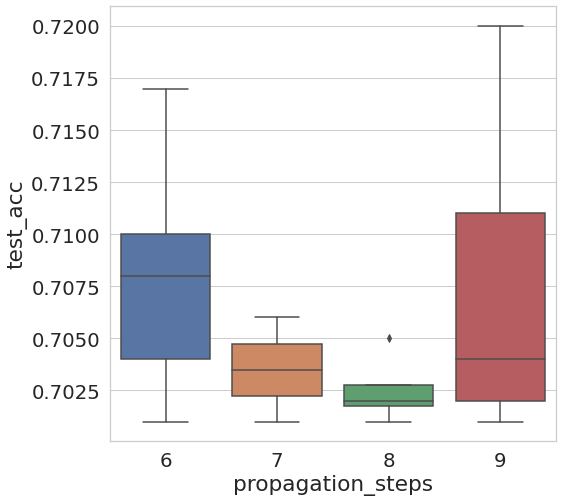

In [30]:
plt.figure(figsize=(8,8))
sns.boxplot(x="propagation_steps", y="test_acc", data=all_logs.query('epoch > 200 & train_acc > 0.9 & test_acc > 0.7 & val_acc > 0.7'))

## **📷 Amazon Photos**

In [31]:
%%capture
path = osp.join(os.getcwd(), 'data')
amazon = load_dataset(path, 'Amazon', params=dict(goods="Photo"))
G = amazon[0].to(device)

In [47]:
TRAIN_SIZE = 200 * 8 # 1600
TEST_SIZE = 4000
VAL_SIZE = 2050

nodes:  7650


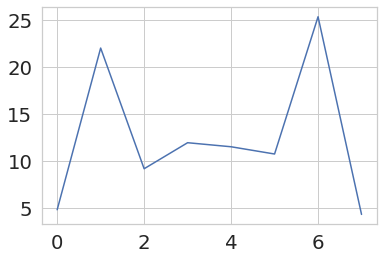

In [40]:
print('nodes: ', G.num_nodes)
plt.plot((torch.bincount(G.y)*100/ G.num_nodes).cpu())

In [66]:
torch.bincount(G.y)

tensor([ 369, 1686,  703,  915,  882,  823, 1941,  331], device='cuda:0')

In [73]:
# Create the train/test/valid split
G.train_mask = torch.tensor([]).int()
G.test_mask = torch.tensor([]).int()
G.val_mask = torch.tensor([]).int()
indices = torch.arange(G.num_nodes)

for label in range(amazon.num_classes):
    label_indices = list(indices[G.y == label].numpy())
    shuffled_indices = torch.randperm(len(label_indices))
    G.train_mask = torch.cat((G.train_mask, shuffled_indices[:200]))
    test_len = (len(label_indices) - 200) * TEST_SIZE // (TEST_SIZE+VAL_SIZE)
    G.test_mask = torch.cat((G.test_mask, shuffled_indices[200:200+test_len]))
    G.val_mask = torch.cat((G.val_mask, shuffled_indices[200+test_len:]))

## **🔍Fine tuning**

In [83]:
grid = dict(
    num_layers=[2,3],
    hidden_dim=[16,24],
    propagation_steps=[5,7,9],
    learning_rate=np.logspace(-4, -1, 5),
    weight_decay=np.logspace(-5, 0, 5),
    dropout=np.linspace(0.4,0.6, 5)
)

In [85]:
id = 0
all_logs=None
best_acc = 0
hyperparameters = list(product(*grid.values()))

for num_layers, hidden_dim, propagation_steps, learning_rate, weight_decay, dropout in tqdm(hyperparameters):
    model, logs, hyperparameters = model_pipeline({
        'id':id,
        'num_layers':num_layers,
        'hidden_dim':hidden_dim,
        'propagation_steps':propagation_steps,
        'learning_rate':learning_rate,
        'weight_decay':weight_decay,
        'num_classes': amazon.num_classes,
        'num_features':amazon.num_features,
        'dropout':dropout,
        'epochs':400,
        'runs':1
    })
    test_acc = logs.query('epoch==399')['test_acc'].iloc[0]
    if test_acc >= best_acc:
        best_acc = test_acc
        print(f"num_layers: {num_layers} \
            | smoothing: {propagation_steps} \
            | dim: {hidden_dim} \
            | train_acc: {train_acc}\
            | test_acc: {test_acc}\
            | val_acc: {val_acc} \n")
    
    if id == 0:
        all_logs = logs
    else:
        all_logs = pd.concat([all_logs, logs], ignore_index=True)
    id += 1

  0%|          | 0/1500 [00:00<?, ?it/s]

NameError: ignored

In [95]:
logs.query('epoch==399').iloc[0].train_acc

0.0006880120274695172

In [ ]:
all_logs.query('epoch == 199 & train_acc == 1.0 & test_acc > 0.7 & val_acc > 0.7').sort_values(by=["test_acc", "val_acc"], ascending=False)